In [28]:

import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

N_DATA = 200

In [29]:
# helper_funcs 
def calculate_agreement(model_labels, pos_neg=None, maj_vote=maj_vote):
    if pos_neg == None:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote)]
        return agreement, np.mean(agreement), len(agreement)
    elif pos_neg == 1:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote) if j == 1]
        return agreement, np.mean(agreement), len(agreement)
    elif pos_neg == 0:
        agreement = [int(i == j) for i, j in zip(model_labels, maj_vote) if j == 0]
        print(len(agreement))
        return agreement, np.mean(agreement), len(agreement)
    
def bootstrap_se(data, n_bootstrap=1000):
    means = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        means.append(np.mean(sample))
    return np.std(means)

def compute_roc_auc(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    return fpr, tpr, roc_auc

In [87]:
mutual_information = json.load(open("data/mutual_information/v2/human_assistant_instruct_0_5000_4_17.json", "r"))
mutual_information = [v["mutual_information"] for v in mutual_information.values()]
llama_labels = json.load(open("data/labels/llama_0_200_answer_first.json", "r"))
gpt4_labels = json.load(open("data/labels/gpt4_0_200_answer_first.json", "r"))["label"]
maj_vote = json.load(open("data/labels/exp_when_9_pp_maj_votes_0_200.json", "r"))

In [88]:
# find best cost param:
mutual_information_median_split = [1 if datum > 2 * np.median(mutual_information) else 0 for datum in mutual_information][:N_DATA]
mi_agreement_combined, mean_mi_agreement_combined, n_mi_combined = calculate_agreement(mutual_information_median_split, pos_neg=None, maj_vote=maj_vote)
mi_agreement_answer_dir, mean_mi_agreement_answer_dir, n_mi_answer_dir = calculate_agreement(mutual_information_median_split, pos_neg=0, maj_vote=maj_vote)
mi_agreement_ask_question, mean_mi_agreement_ask_question, n_mi_ask_question = calculate_agreement(mutual_information_median_split, pos_neg=1, maj_vote=maj_vote)
print(mean_mi_agreement_combined, mean_mi_agreement_answer_dir, mean_mi_agreement_ask_question)

124
0.75 0.8387096774193549 0.6052631578947368


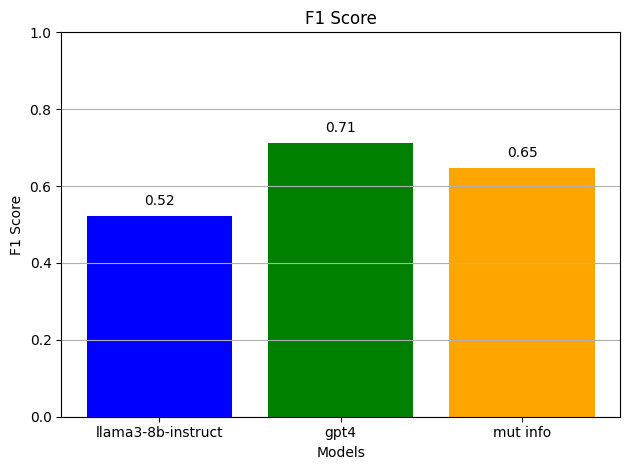

In [89]:
# Compute F1 scores for each model
llama_f1 = f1_score(maj_vote, llama_labels, average='binary')
gpt4_f1 = f1_score(maj_vote, gpt4_labels, average='binary')
mi_f1 = f1_score(maj_vote, mutual_information_median_split , average='binary')

# Plotting
models = ['llama3-8b-instruct', 'gpt4', 'mut info']
f1_scores = [llama_f1, gpt4_f1, mi_f1]

fig, ax = plt.subplots()
ax.bar(models, f1_scores, color=['blue', 'green', 'orange'])
ax.set_xlabel('Models')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score')
ax.set_ylim(0, 1)  # Setting y-axis limit from 0 to 1 for F1 score
ax.grid(axis='y')

# Adding text annotations with the exact F1 scores on top of each bar
for i, score in enumerate(f1_scores):
    ax.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

0.69
124
124
124


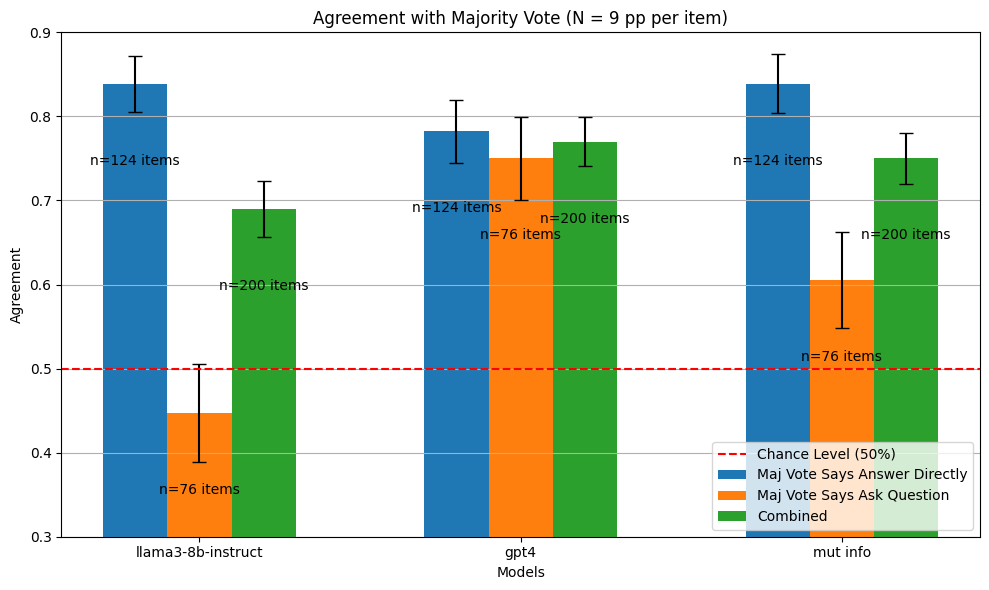

In [90]:
# Compute agreements for pos_neg == None, 0, and 1
llama_agreement_combined, mean_llama_agreement_combined, n_llama_combined = calculate_agreement(llama_labels, pos_neg=None, maj_vote=maj_vote)
gpt4_agreement_combined, mean_gpt4_agreement_combined, n_gpt4_combined = calculate_agreement(gpt4_labels, pos_neg=None, maj_vote=maj_vote)
mi_agreement_combined, mean_mi_agreement_combined, n_mi_combined = calculate_agreement(mutual_information_median_split, pos_neg=None, maj_vote=maj_vote)
print(mean_llama_agreement_combined)
llama_agreement_answer_dir, mean_llama_agreement_answer_dir, n_llama_answer_dir = calculate_agreement(llama_labels, pos_neg=0, maj_vote=maj_vote)
gpt4_agreement_answer_dir, mean_gpt4_agreement_answer_dir, n_gpt4_answer_dir = calculate_agreement(gpt4_labels, pos_neg=0, maj_vote=maj_vote)
mi_agreement_answer_dir, mean_mi_agreement_answer_dir, n_mi_answer_dir = calculate_agreement(mutual_information_median_split, pos_neg=0, maj_vote=maj_vote)

llama_agreement_ask_question, mean_llama_agreement_ask_question, n_llama_ask_question = calculate_agreement(llama_labels, pos_neg=1, maj_vote=maj_vote)
gpt4_agreement_ask_question, mean_gpt4_agreement_ask_question, n_gpt4_ask_question = calculate_agreement(gpt4_labels, pos_neg=1, maj_vote=maj_vote)
mi_agreement_ask_question, mean_mi_agreement_ask_question, n_mi_ask_question = calculate_agreement(mutual_information_median_split, pos_neg=1, maj_vote=maj_vote)

# Bootstrapped standard error calculation
llama_boot_se_combined = bootstrap_se(llama_agreement_combined)
gpt4_boot_se_combined = bootstrap_se(gpt4_agreement_combined)
mi_boot_se_combined = bootstrap_se(mi_agreement_combined)

llama_boot_se_answer_dir = bootstrap_se(llama_agreement_answer_dir)
gpt4_boot_se_answer_dir = bootstrap_se(gpt4_agreement_answer_dir)
mi_boot_se_answer_dir = bootstrap_se(mi_agreement_answer_dir)

llama_boot_se_ask_question = bootstrap_se(llama_agreement_ask_question)
gpt4_boot_se_ask_question = bootstrap_se(gpt4_agreement_ask_question)
mi_boot_se_ask_question = bootstrap_se(mi_agreement_ask_question)

# Plotting
models = ['llama3-8b-instruct', 'gpt4', 'mut info']
labels = ['Maj Vote Says Answer Directly', 'Maj Vote Says Ask Question', 'Combined']
agreements = [
    [mean_llama_agreement_answer_dir, mean_llama_agreement_ask_question, mean_llama_agreement_combined],
    [mean_gpt4_agreement_answer_dir, mean_gpt4_agreement_ask_question, mean_gpt4_agreement_combined],
    [mean_mi_agreement_answer_dir, mean_mi_agreement_ask_question, mean_mi_agreement_combined]
]
n_values = [
    [n_llama_answer_dir, n_llama_ask_question, n_llama_combined],
    [n_gpt4_answer_dir, n_gpt4_ask_question, n_gpt4_combined],
    [n_mi_answer_dir, n_mi_ask_question, n_mi_combined]
]
boot_se_values = [
    [llama_boot_se_answer_dir, llama_boot_se_ask_question, llama_boot_se_combined],
    [gpt4_boot_se_answer_dir, gpt4_boot_se_ask_question, gpt4_boot_se_combined],
    [mi_boot_se_answer_dir, mi_boot_se_ask_question, mi_boot_se_combined]
]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(labels)):
    ax.bar(x + i * width - width, [agreements[j][i] for j in range(len(models))], width, label=labels[i], yerr=[boot_se_values[j][i] for j in range(len(models))], capsize=5)
    for j in range(len(models)):
        ax.text(x[j] + i * width - width, agreements[j][i] - 0.1, f'n={n_values[j][i]} items', ha='center', va='bottom')

ax.axhline(y=0.5, color='r', linestyle='--', label='Chance Level (50%)')
ax.set_xlabel('Models')
ax.set_ylabel('Agreement')
ax.set_title('Agreement with Majority Vote (N = 9 pp per item)')
ax.set_xticks(x)
ax.set_ylim(.3, .9)
ax.grid(axis='y')
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


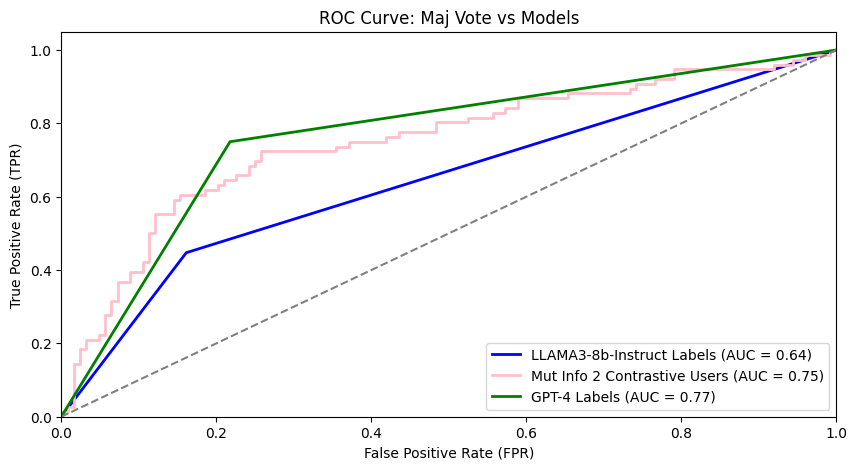

In [91]:
# Compute ROC curves f
fpr_llama, tpr_llama, roc_auc_llama = compute_roc_auc(maj_vote, llama_labels)
fpr_gpt4, tpr_gpt4, roc_auc_gpt4 = compute_roc_auc(maj_vote, gpt4_labels)
fpr_mi_2, tpr_mi_2, roc_auc_mi_2 = compute_roc_auc(maj_vote, mutual_information[:N_DATA])

# Plot ROC curves
plt.figure(figsize=(10, 5))
plt.plot(fpr_llama, tpr_llama, color='blue', lw=2, label=f'LLAMA3-8b-Instruct Labels (AUC = {roc_auc_llama:.2f})')
plt.plot(fpr_mi_2, tpr_mi_2, color='pink', lw=2, label=f'Mut Info 2 Contrastive Users (AUC = {roc_auc_mi_2:.2f})')
# plt.plot(fpr_mi_3, tpr_mi_3, color='orange', lw=2, label=f'Mut Info 3 Users (AUC = {roc_auc_mi_3:.2f})')
# plt.plot(fpr_mi_4, tpr_mi_4, color='black', lw=2, label=f'Mut Info 4 Users (AUC = {roc_auc_mi_4:.2f})')
plt.plot(fpr_gpt4, tpr_gpt4, color='green', lw=2, label=f'GPT-4 Labels (AUC = {roc_auc_gpt4:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Maj Vote vs Models')
plt.legend(loc="lower right")
plt.show()

In [92]:
# Load behavior data 
llama38b_behavior = json.load(open('results/base_questions.json'))
stargate_epoch_1 = json.load(open('results/cot_distilled_epoch_1_questions.json'))
stargate_epoch_2 = json.load(open('results/cot_distilled_epoch_2_questions.json'))
stargate_epoch_3 = json.load(open('results/cot_distilled_epoch_3_questions.json'))

stargate_epoch_1_no_cot = json.load(open('results/not_cot_distilled_epoch_1_questions.json'))
stargate_epoch_2_no_cot = json.load(open('results/not_cot_distilled_epoch_2_questions.json'))
stargate_epoch_3_no_cot = json.load(open('results/not_cot_distilled_epoch_3_questions.json'))


/tmp/user/22820/ipykernel_3061534/3558462694.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)


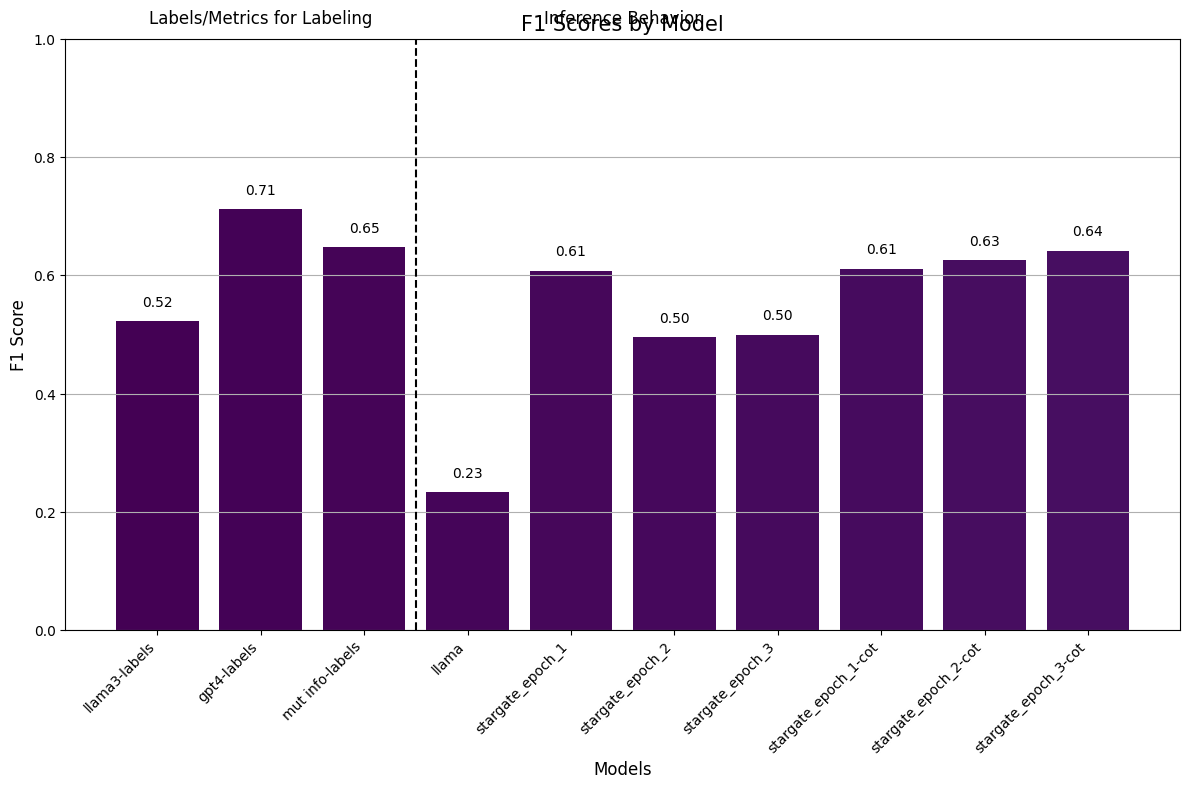

In [93]:


# Compute F1 scores for each model
llama_lf = f1_score(maj_vote, llama_labels, average='binary')
gpt4_f1 = f1_score(maj_vote, gpt4_labels, average='binary')
mi = f1_score(maj_vote, mutual_information_median_split, average='binary')

llama_f1 = f1_score(maj_vote, llama38b_behavior, average='binary')
stargate_f1_epoch_1 = f1_score(maj_vote, stargate_epoch_1, average='binary')
stargate_f1_epoch_2 = f1_score(maj_vote, stargate_epoch_2, average='binary')
stargate_f1_epoch_3 = f1_score(maj_vote, stargate_epoch_3, average='binary')
stargate_f1_epoch_1_not_cot = f1_score(maj_vote, stargate_epoch_1_no_cot , average='binary')
stargate_f1_epoch_2_not_cot = f1_score(maj_vote, stargate_epoch_2_no_cot, average='binary')
stargate_f1_epoch_3_not_cot = f1_score(maj_vote, stargate_epoch_3_no_cot, average='binary')

# Plotting
models = ['llama3-labels', 'gpt4-labels', 'mut info-labels', 'llama', 'stargate_epoch_1', 'stargate_epoch_2', 'stargate_epoch_3', 'stargate_epoch_1-cot', 'stargate_epoch_2-cot', 'stargate_epoch_3-cot']
f1_scores = [llama_lf, gpt4_f1, mi, llama_f1, stargate_f1_epoch_1_not_cot, stargate_f1_epoch_2_not_cot, stargate_f1_epoch_3_not_cot, stargate_f1_epoch_1, stargate_f1_epoch_2, stargate_f1_epoch_3]

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(models, f1_scores, color=plt.cm.viridis(range(len(models))))

# Adding the vertical bar and labels
plt.axvline(x=2.5, color='black', linestyle='--')
ax.text(1, 1.02, 'Labels/Metrics for Labeling', ha='center', va='bottom', fontsize=12)
ax.text(4.5, 1.02, 'Inference Behavior', ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Scores by Model', fontsize=15)
ax.set_ylim(0, 1)  # Setting y-axis limit from 0 to 1 for F1 score
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.grid(axis='y')

# Adding text annotations with the exact F1 scores on top of each bar
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/user/22820/ipykernel_3061534/1687964180.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)


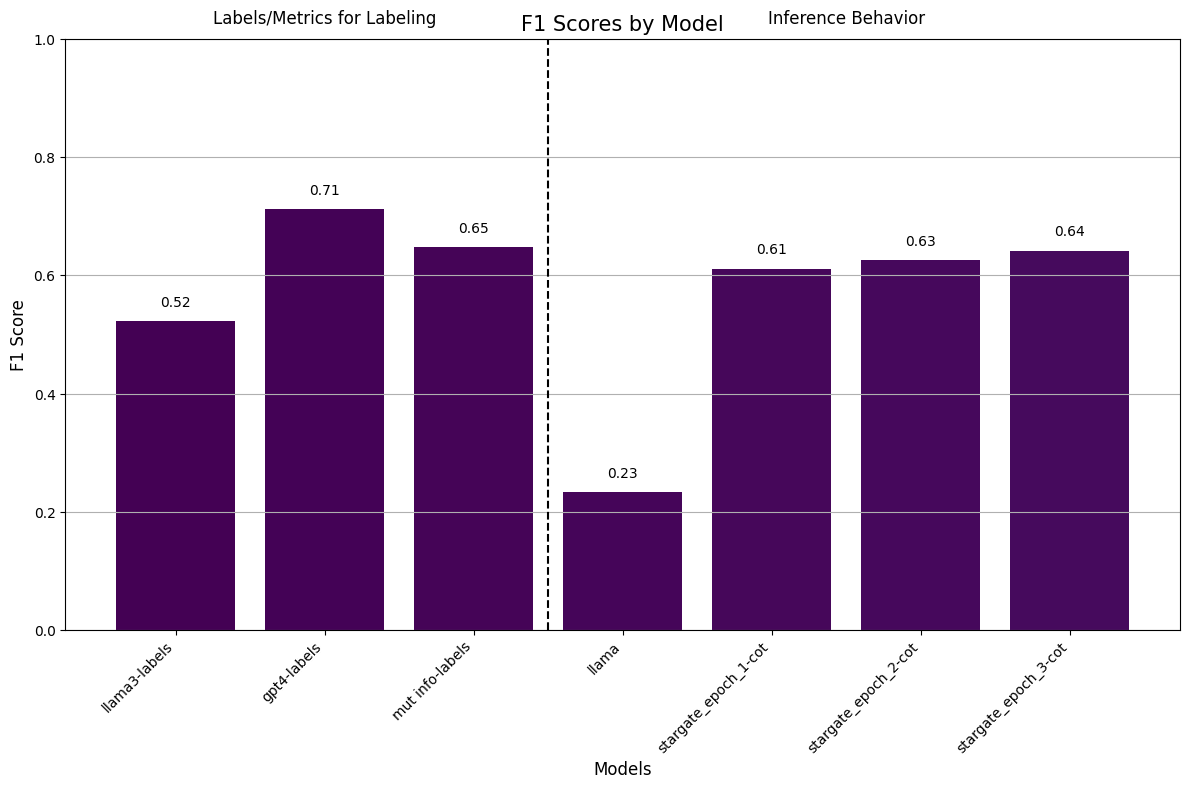

In [103]:


# Compute F1 scores for each model
llama_lf = f1_score(maj_vote, llama_labels, average='binary')
gpt4_f1 = f1_score(maj_vote, gpt4_labels, average='binary')
mi = f1_score(maj_vote, mutual_information_median_split, average='binary')

llama_f1 = f1_score(maj_vote, llama38b_behavior, average='binary')
stargate_f1_epoch_1 = f1_score(maj_vote, stargate_epoch_1, average='binary')
stargate_f1_epoch_2 = f1_score(maj_vote, stargate_epoch_2, average='binary')
stargate_f1_epoch_3 = f1_score(maj_vote, stargate_epoch_3, average='binary')
stargate_f1_epoch_1_not_cot = f1_score(maj_vote, stargate_epoch_1_no_cot , average='binary')
stargate_f1_epoch_2_not_cot = f1_score(maj_vote, stargate_epoch_2_no_cot, average='binary')
stargate_f1_epoch_3_not_cot = f1_score(maj_vote, stargate_epoch_3_no_cot, average='binary')

# Plotting
models = ['llama3-labels', 'gpt4-labels', 'mut info-labels', 'llama',  'stargate_epoch_1-cot', 'stargate_epoch_2-cot', 'stargate_epoch_3-cot']
f1_scores = [llama_lf, gpt4_f1, mi, llama_f1, stargate_f1_epoch_1, stargate_f1_epoch_2, stargate_f1_epoch_3]

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(models, f1_scores, color=plt.cm.viridis(range(len(models))))

# Adding the vertical bar and labels
plt.axvline(x=2.5, color='black', linestyle='--')
ax.text(1, 1.02, 'Labels/Metrics for Labeling', ha='center', va='bottom', fontsize=12)
ax.text(4.5, 1.02, 'Inference Behavior', ha='center', va='bottom', fontsize=12)

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Scores by Model', fontsize=15)
ax.set_ylim(0, 1)  # Setting y-axis limit from 0 to 1 for F1 score
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax.grid(axis='y')

# Adding text annotations with the exact F1 scores on top of each bar
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

124
124
124
124
124
124
124
124
124
124


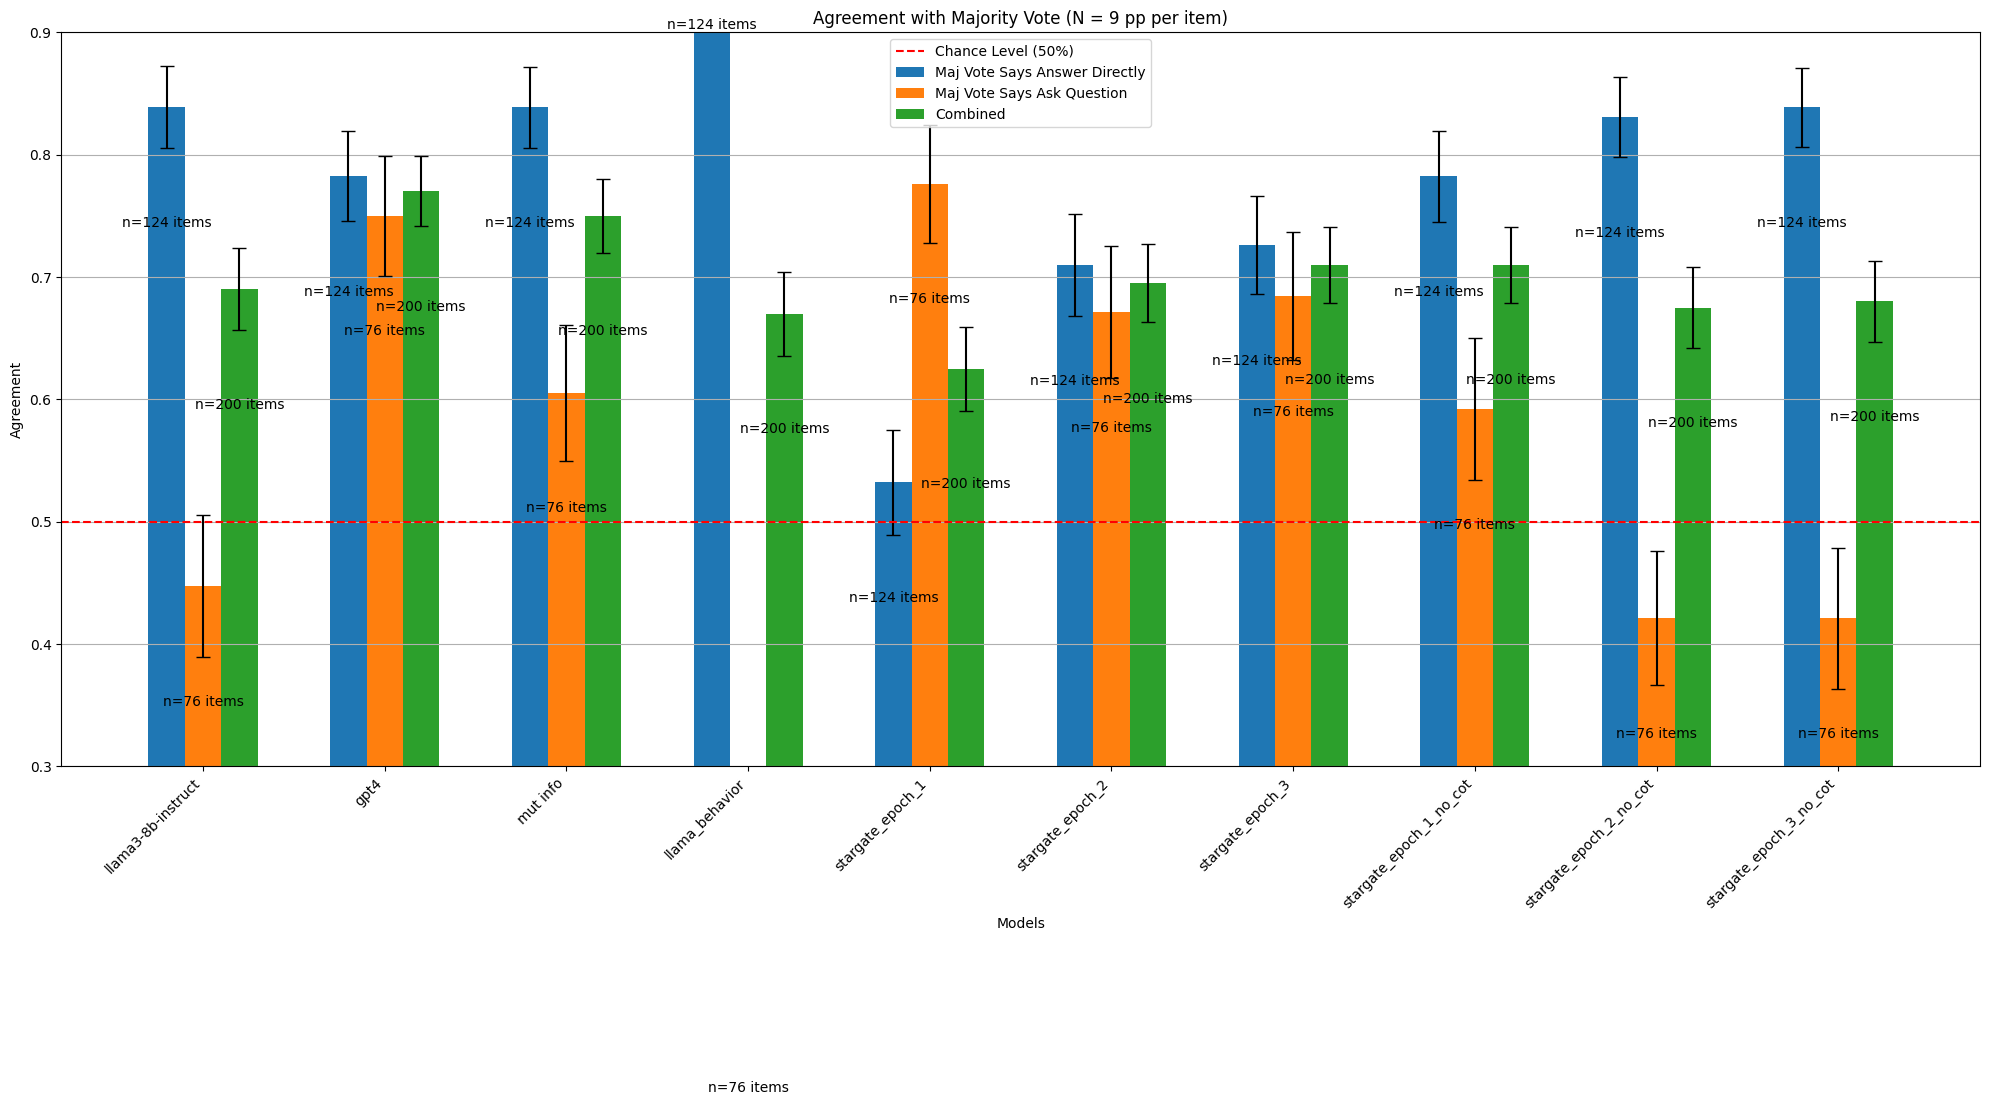

In [95]:


# Compute agreements
llama_agreement_combined, mean_llama_agreement_combined, n_llama_combined = calculate_agreement(llama_labels, pos_neg=None, maj_vote=maj_vote)
gpt4_agreement_combined, mean_gpt4_agreement_combined, n_gpt4_combined = calculate_agreement(gpt4_labels, pos_neg=None, maj_vote=maj_vote)
mi_agreement_combined, mean_mi_agreement_combined, n_mi_combined = calculate_agreement(mutual_information_median_split, pos_neg=None, maj_vote=maj_vote)
llama_behavior_agreement_combined, mean_llama_behavior_agreement_combined, n_llama_behavior_combined = calculate_agreement(llama38b_behavior, pos_neg=None, maj_vote=maj_vote)

llama_agreement_answer_dir, mean_llama_agreement_answer_dir, n_llama_answer_dir = calculate_agreement(llama_labels, pos_neg=0, maj_vote=maj_vote)
gpt4_agreement_answer_dir, mean_gpt4_agreement_answer_dir, n_gpt4_answer_dir = calculate_agreement(gpt4_labels, pos_neg=0, maj_vote=maj_vote)
mi_agreement_answer_dir, mean_mi_agreement_answer_dir, n_mi_answer_dir = calculate_agreement(mutual_information_median_split, pos_neg=0, maj_vote=maj_vote)
llama_behavior_agreement_answer_dir, mean_llama_behavior_agreement_answer_dir, n_llama_behavior_answer_dir = calculate_agreement(llama38b_behavior, pos_neg=0, maj_vote=maj_vote)

llama_agreement_ask_question, mean_llama_agreement_ask_question, n_llama_ask_question = calculate_agreement(llama_labels, pos_neg=1, maj_vote=maj_vote)
gpt4_agreement_ask_question, mean_gpt4_agreement_ask_question, n_gpt4_ask_question = calculate_agreement(gpt4_labels, pos_neg=1, maj_vote=maj_vote)
mi_agreement_ask_question, mean_mi_agreement_ask_question, n_mi_ask_question = calculate_agreement(mutual_information_median_split, pos_neg=1, maj_vote=maj_vote)
llama_behavior_agreement_ask_question, mean_llama_behavior_agreement_ask_question, n_llama_behavior_ask_question = calculate_agreement(llama38b_behavior, pos_neg=1, maj_vote=maj_vote)

# Bootstrapped standard error calculation
llama_boot_se_combined = bootstrap_se(llama_agreement_combined)
gpt4_boot_se_combined = bootstrap_se(gpt4_agreement_combined)
mi_boot_se_combined = bootstrap_se(mi_agreement_combined)
llama_behavior_boot_se_combined = bootstrap_se(llama_behavior_agreement_combined)

llama_boot_se_answer_dir = bootstrap_se(llama_agreement_answer_dir)
gpt4_boot_se_answer_dir = bootstrap_se(gpt4_agreement_answer_dir)
mi_boot_se_answer_dir = bootstrap_se(mi_agreement_answer_dir)
llama_behavior_boot_se_answer_dir = bootstrap_se(llama_behavior_agreement_answer_dir)

llama_boot_se_ask_question = bootstrap_se(llama_agreement_ask_question)
gpt4_boot_se_ask_question = bootstrap_se(gpt4_agreement_ask_question)
mi_boot_se_ask_question = bootstrap_se(mi_agreement_ask_question)
llama_behavior_boot_se_ask_question = bootstrap_se(llama_behavior_agreement_ask_question)

# Compute agreements for additional models
stargate_agreement_combined = []
stargate_mean_agreement_combined = []
stargate_n_combined = []
stargate_agreement_answer_dir = []
stargate_mean_agreement_answer_dir = []
stargate_n_answer_dir = []
stargate_agreement_ask_question = []
stargate_mean_agreement_ask_question = []
stargate_n_ask_question = []

stargate_agreement_combined_no_cot = []
stargate_mean_agreement_combined_no_cot = []
stargate_n_combined_no_cot = []
stargate_agreement_answer_dir_no_cot = []
stargate_mean_agreement_answer_dir_no_cot = []
stargate_n_answer_dir_no_cot = []
stargate_agreement_ask_question_no_cot = []
stargate_mean_agreement_ask_question_no_cot = []
stargate_n_ask_question_no_cot = []

for epoch_data, epoch_data_no_cot in zip([stargate_epoch_1, stargate_epoch_2, stargate_epoch_3], [stargate_epoch_1_no_cot, stargate_epoch_2_no_cot, stargate_epoch_3_no_cot]):
    agreement_combined, mean_agreement_combined, n_combined = calculate_agreement(epoch_data, pos_neg=None, maj_vote=maj_vote)
    agreement_answer_dir, mean_agreement_answer_dir, n_answer_dir = calculate_agreement(epoch_data, pos_neg=0, maj_vote=maj_vote)
    agreement_ask_question, mean_agreement_ask_question, n_ask_question = calculate_agreement(epoch_data, pos_neg=1, maj_vote=maj_vote)
    
    agreement_combined_no_cot, mean_agreement_combined_no_cot, n_combined_no_cot = calculate_agreement(epoch_data_no_cot, pos_neg=None, maj_vote=maj_vote)
    agreement_answer_dir_no_cot, mean_agreement_answer_dir_no_cot, n_answer_dir_no_cot = calculate_agreement(epoch_data_no_cot, pos_neg=0, maj_vote=maj_vote)
    agreement_ask_question_no_cot, mean_agreement_ask_question_no_cot, n_ask_question_no_cot = calculate_agreement(epoch_data_no_cot, pos_neg=1, maj_vote=maj_vote)
    
    stargate_agreement_combined.append(agreement_combined)
    stargate_mean_agreement_combined.append(mean_agreement_combined)
    stargate_n_combined.append(n_combined)
    stargate_agreement_answer_dir.append(agreement_answer_dir)
    stargate_mean_agreement_answer_dir.append(mean_agreement_answer_dir)
    stargate_n_answer_dir.append(n_answer_dir)
    stargate_agreement_ask_question.append(agreement_ask_question)
    stargate_mean_agreement_ask_question.append(mean_agreement_ask_question)
    stargate_n_ask_question.append(n_ask_question)
    
    stargate_agreement_combined_no_cot.append(agreement_combined_no_cot)
    stargate_mean_agreement_combined_no_cot.append(mean_agreement_combined_no_cot)
    stargate_n_combined_no_cot.append(n_combined_no_cot)
    stargate_agreement_answer_dir_no_cot.append(agreement_answer_dir_no_cot)
    stargate_mean_agreement_answer_dir_no_cot.append(mean_agreement_answer_dir_no_cot)
    stargate_n_answer_dir_no_cot.append(n_answer_dir_no_cot)
    stargate_agreement_ask_question_no_cot.append(agreement_ask_question_no_cot)
    stargate_mean_agreement_ask_question_no_cot.append(mean_agreement_ask_question_no_cot)
    stargate_n_ask_question_no_cot.append(n_ask_question_no_cot)

# Bootstrapped standard error calculation for additional models
stargate_boot_se_combined = [bootstrap_se(data) for data in stargate_agreement_combined]
stargate_boot_se_answer_dir = [bootstrap_se(data) for data in stargate_agreement_answer_dir]
stargate_boot_se_ask_question = [bootstrap_se(data) for data in stargate_agreement_ask_question]

stargate_boot_se_combined_no_cot = [bootstrap_se(data) for data in stargate_agreement_combined_no_cot]
stargate_boot_se_answer_dir_no_cot = [bootstrap_se(data) for data in stargate_agreement_answer_dir_no_cot]
stargate_boot_se_ask_question_no_cot = [bootstrap_se(data) for data in stargate_agreement_ask_question_no_cot]

# Plotting
models = ['llama3-8b-instruct', 'gpt4', 'mut info', 'llama_behavior', 'stargate_epoch_1', 'stargate_epoch_2', 'stargate_epoch_3', 'stargate_epoch_1_no_cot', 'stargate_epoch_2_no_cot', 'stargate_epoch_3_no_cot']
labels = ['Maj Vote Says Answer Directly', 'Maj Vote Says Ask Question', 'Combined']

agreements = [
    [mean_llama_agreement_answer_dir, mean_llama_agreement_ask_question, mean_llama_agreement_combined],
    [mean_gpt4_agreement_answer_dir, mean_gpt4_agreement_ask_question, mean_gpt4_agreement_combined],
    [mean_mi_agreement_answer_dir, mean_mi_agreement_ask_question, mean_mi_agreement_combined],
    [mean_llama_behavior_agreement_answer_dir, mean_llama_behavior_agreement_ask_question, mean_llama_behavior_agreement_combined]
] + [
    [mean_agreement_answer_dir, mean_agreement_ask_question, mean_agreement_combined]
    for mean_agreement_answer_dir, mean_agreement_ask_question, mean_agreement_combined
    in zip(stargate_mean_agreement_answer_dir, stargate_mean_agreement_ask_question, stargate_mean_agreement_combined)
] + [
    [mean_agreement_answer_dir_no_cot, mean_agreement_ask_question_no_cot, mean_agreement_combined_no_cot]
    for mean_agreement_answer_dir_no_cot, mean_agreement_ask_question_no_cot, mean_agreement_combined_no_cot
    in zip(stargate_mean_agreement_answer_dir_no_cot, stargate_mean_agreement_ask_question_no_cot, stargate_mean_agreement_combined_no_cot)
]

n_values = [
    [n_llama_answer_dir, n_llama_ask_question, n_llama_combined],
    [n_gpt4_answer_dir, n_gpt4_ask_question, n_gpt4_combined],
    [n_mi_answer_dir, n_mi_ask_question, n_mi_combined],
    [n_llama_behavior_answer_dir, n_llama_behavior_ask_question, n_llama_behavior_combined]
] + [
    [n_answer_dir, n_ask_question, n_combined]
    for n_answer_dir, n_ask_question, n_combined
    in zip(stargate_n_answer_dir, stargate_n_ask_question, stargate_n_combined)
] + [
    [n_answer_dir_no_cot, n_ask_question_no_cot, n_combined_no_cot]
    for n_answer_dir_no_cot, n_ask_question_no_cot, n_combined_no_cot
    in zip(stargate_n_answer_dir_no_cot, stargate_n_ask_question_no_cot, stargate_n_combined_no_cot)
]

boot_se_values = [
    [llama_boot_se_answer_dir, llama_boot_se_ask_question, llama_boot_se_combined],
    [gpt4_boot_se_answer_dir, gpt4_boot_se_ask_question, gpt4_boot_se_combined],
    [mi_boot_se_answer_dir, mi_boot_se_ask_question, mi_boot_se_combined],
    [llama_behavior_boot_se_answer_dir, llama_behavior_boot_se_ask_question, llama_behavior_boot_se_combined]
] + [
    [boot_se_answer_dir, boot_se_ask_question, boot_se_combined]
    for boot_se_answer_dir, boot_se_ask_question, boot_se_combined
    in zip(stargate_boot_se_answer_dir, stargate_boot_se_ask_question, stargate_boot_se_combined)
] + [
    [boot_se_answer_dir_no_cot, boot_se_ask_question_no_cot, boot_se_combined_no_cot]
    for boot_se_answer_dir_no_cot, boot_se_ask_question_no_cot, boot_se_combined_no_cot
    in zip(stargate_boot_se_answer_dir_no_cot, stargate_boot_se_ask_question_no_cot, stargate_boot_se_combined_no_cot)
]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(20, 12))

for i in range(len(labels)):
    ax.bar(x + i * width - width, [agreements[j][i] for j in range(len(models))], width, label=labels[i], yerr=[boot_se_values[j][i] for j in range(len(models))], capsize=5)
    for j in range(len(models)):
        ax.text(x[j] + i * width - width, agreements[j][i] - 0.1, f'n={n_values[j][i]} items', ha='center', va='bottom')

ax.axhline(y=0.5, color='r', linestyle='--', label='Chance Level (50%)')
ax.set_xlabel('Models')
ax.set_ylabel('Agreement')
ax.set_title('Agreement with Majority Vote (N = 9 pp per item)')
ax.set_xticks(x)
ax.set_ylim(.3, .9)
ax.grid(axis='y')
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


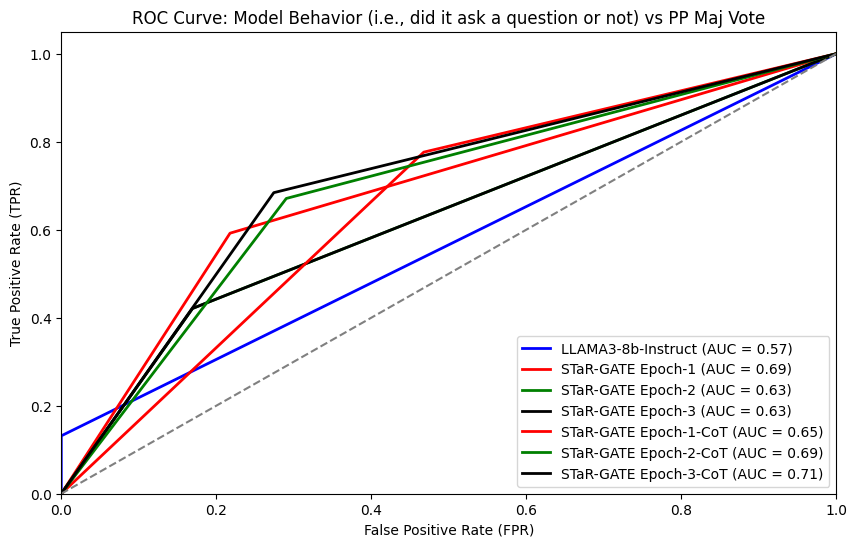

In [64]:


# Compute ROC AUC
fpr_llama, tpr_llama, roc_auc_llama = compute_roc_auc(maj_vote, llama38b_behavior)
fpr_epoch_1_no_cot, tpr_epoch_1_no_cot, roc_auc_epoch_1_no_cot = compute_roc_auc(maj_vote, stargate_epoch_1_no_cot)
fpr_epoch_2_no_cot, tpr_epoch_2_no_cot, roc_auc_epoch_2_no_cot = compute_roc_auc(maj_vote, stargate_epoch_2_no_cot)
fpr_epoch_3_no_cot, tpr_epoch_3_no_cot, roc_auc_epoch_3_no_cot = compute_roc_auc(maj_vote, stargate_epoch_3_no_cot)
fpr_epoch_1, tpr_epoch_1, roc_auc_epoch_1 = compute_roc_auc(maj_vote, stargate_epoch_1)
fpr_epoch_2, tpr_epoch_2, roc_auc_epoch_2 = compute_roc_auc(maj_vote, stargate_epoch_2)
fpr_epoch_3, tpr_epoch_3, roc_auc_epoch_3 = compute_roc_auc(maj_vote, stargate_epoch_3)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_llama, tpr_llama, color='blue', lw=2, label=f'LLAMA3-8b-Instruct (AUC = {roc_auc_llama:.2f})')
plt.plot(fpr_epoch_1_no_cot, tpr_epoch_1_no_cot, color='red', lw=2, label=f'STaR-GATE Epoch-1 (AUC = {roc_auc_epoch_1_no_cot:.2f})')
plt.plot(fpr_epoch_2_no_cot, tpr_epoch_2_no_cot, color='green', lw=2, label=f'STaR-GATE Epoch-2 (AUC = {roc_auc_epoch_2_no_cot:.2f})')
plt.plot(fpr_epoch_3_no_cot, tpr_epoch_3_no_cot, color='black', lw=2, label=f'STaR-GATE Epoch-3 (AUC = {roc_auc_epoch_3_no_cot:.2f})')
plt.plot(fpr_epoch_1, tpr_epoch_1, color='red', lw=2, label=f'STaR-GATE Epoch-1-CoT (AUC = {roc_auc_epoch_1:.2f})')
plt.plot(fpr_epoch_2, tpr_epoch_2, color='green', lw=2, label=f'STaR-GATE Epoch-2-CoT (AUC = {roc_auc_epoch_2:.2f})')
plt.plot(fpr_epoch_3, tpr_epoch_3, color='black', lw=2, label=f'STaR-GATE Epoch-3-CoT (AUC = {roc_auc_epoch_3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Model Behavior (i.e., did it ask a question or not) vs PP Maj Vote')
plt.legend(loc="lower right")
plt.show()


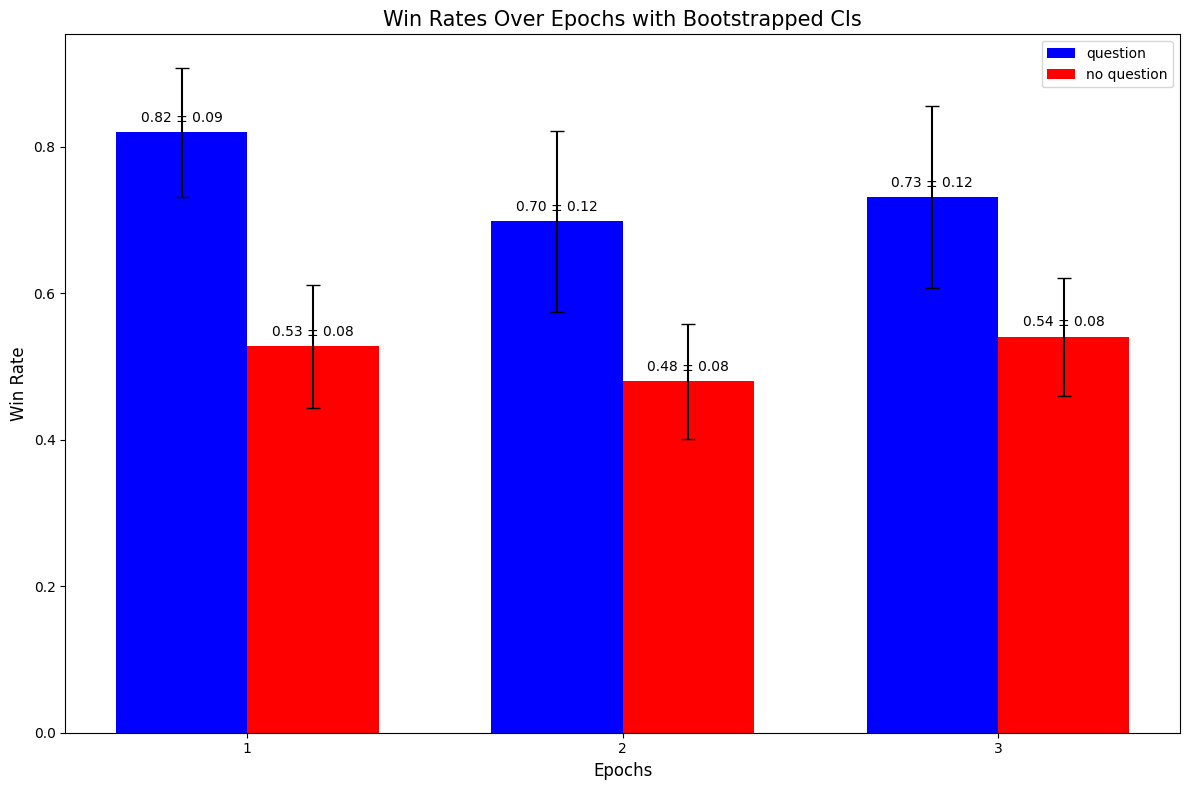

In [110]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load win rates data
win_rates_no_cot_1 = json.load(open("results/not_cot_distilled_epoch_1_win_rates.json", "r"))
win_rates_no_cot_1_q = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 1]
win_rates_no_cot_1_nq = [w for w, q in zip(win_rates_no_cot_1, stargate_epoch_1_no_cot) if q == 0]

win_rates_no_cot_2 = json.load(open("results/not_cot_distilled_epoch_2_win_rates.json", "r"))
win_rates_no_cot_2_q = [w for w, q in zip(win_rates_no_cot_2, stargate_epoch_2_no_cot) if q == 1]
win_rates_no_cot_2_nq = [w for w, q in zip(win_rates_no_cot_2, stargate_epoch_2_no_cot) if q == 0]

win_rates_no_cot_3 = json.load(open("results/not_cot_distilled_epoch_3_win_rates.json", "r"))
win_rates_no_cot_3_q = [w for w, q in zip(win_rates_no_cot_3, stargate_epoch_3_no_cot) if q == 1]
win_rates_no_cot_3_nq = [w for w, q in zip(win_rates_no_cot_3, stargate_epoch_3_no_cot) if q == 0]

# Calculate means and CIs
epochs = [1, 2, 3]
win_rates_no_cot_q = [win_rates_no_cot_1_q, win_rates_no_cot_2_q, win_rates_no_cot_3_q]
win_rates_no_cot_nq = [win_rates_no_cot_1_nq, win_rates_no_cot_2_nq, win_rates_no_cot_3_nq]

mean_no_cot_q = [np.mean(win_rate) for win_rate in win_rates_no_cot_q]
mean_no_cot_nq = [np.mean(win_rate) for win_rate in win_rates_no_cot_nq]

ci_no_cot_q = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_q]
ci_no_cot_nq = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_no_cot_nq]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(epochs))

bars1 = ax.bar(index, mean_no_cot_q, bar_width, yerr=ci_no_cot_q, label='question', color='blue', capsize=5)
bars2 = ax.bar(index + bar_width, mean_no_cot_nq, bar_width, yerr=ci_no_cot_nq, label='no question', color='red', capsize=5)

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Win Rate', fontsize=12)
ax.set_title('Win Rates Over Epochs with Bootstrapped CIs', fontsize=15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(epochs)
ax.legend()

# Adding text annotations with the exact win rates on top of each bar
for bars, mean, ci in zip([bars1, bars2], [mean_no_cot_q, mean_no_cot_nq], [ci_no_cot_q, ci_no_cot_nq]):
    for bar, m, c in zip(bars, mean, ci):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{m:.2f} ± {c:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


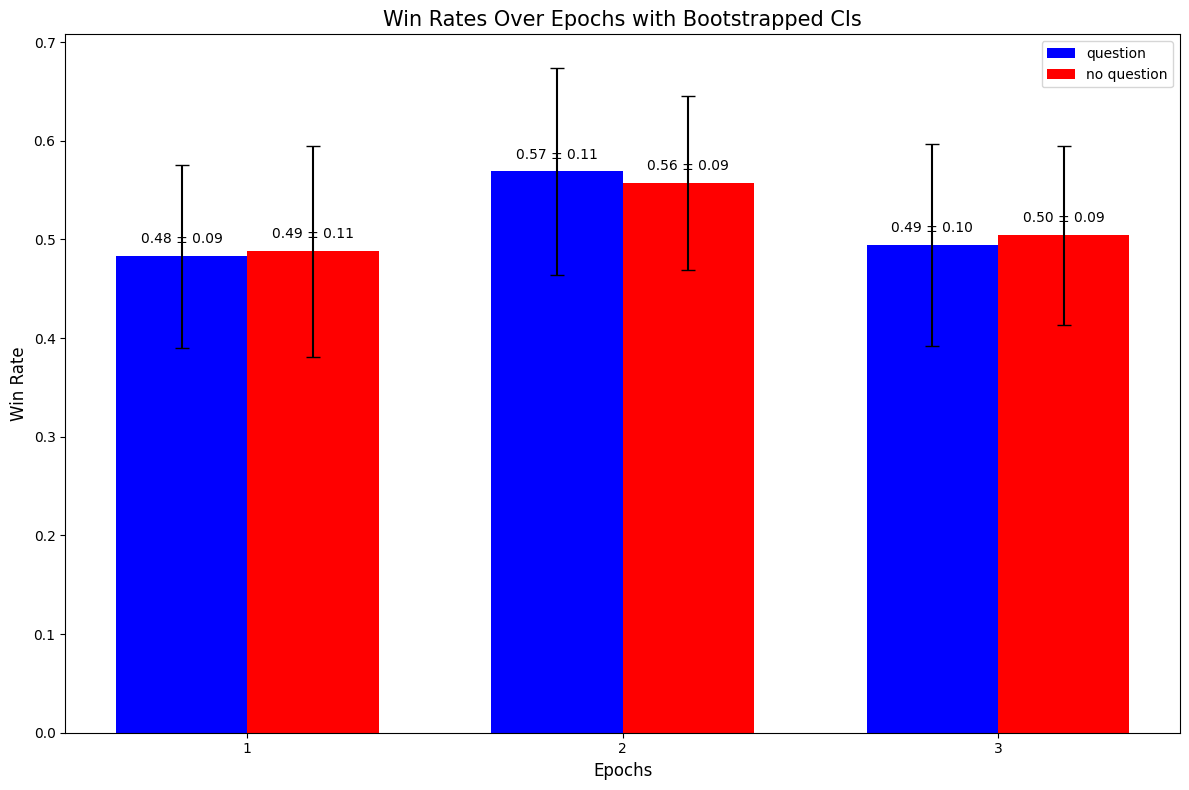

In [109]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load win rates data
win_rates_cot_1 = json.load(open("results/cot_distilled_epoch_1_win_rates.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1) if q == 0]

win_rates_cot_2 = json.load(open("results/cot_distilled_epoch_2_win_rates.json", "r"))
win_rates_cot_2_q = [w for w, q in zip(win_rates_cot_2, stargate_epoch_2) if q == 1]
win_rates_cot_2_nq = [w for w, q in zip(win_rates_cot_2, stargate_epoch_2) if q == 0]

win_rates_cot_3 = json.load(open("results/cot_distilled_epoch_3_win_rates.json", "r"))
win_rates_cot_3_q = [w for w, q in zip(win_rates_cot_3, stargate_epoch_3) if q == 1]
win_rates_cot_3_nq = [w for w, q in zip(win_rates_cot_3, stargate_epoch_3) if q == 0]

# Calculate means and CIs
epochs = [1, 2, 3]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_2_q, win_rates_cot_3_q]
win_rates_cot_nq = [win_rates_cot_1_nq, win_rates_cot_2_nq, win_rates_cot_3_nq]

mean_cot_q = [np.mean(win_rate) for win_rate in win_rates_cot_q]
mean_cot_nq = [np.mean(win_rate) for win_rate in win_rates_cot_nq]

ci_cot_q = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]
ci_cot_nq = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_nq]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(epochs))

bars1 = ax.bar(index, mean_cot_q, bar_width, yerr=ci_cot_q, label='question', color='blue', capsize=5)
bars2 = ax.bar(index + bar_width, mean_cot_nq, bar_width, yerr=ci_cot_nq, label='no question', color='red', capsize=5)

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Win Rate', fontsize=12)
ax.set_title('Win Rates Over Epochs with Bootstrapped CIs', fontsize=15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(epochs)
ax.legend()

# Adding text annotations with the exact win rates on top of each bar
for bars, mean, ci in zip([bars1, bars2], [mean_cot_q, mean_cot_nq], [ci_cot_q, ci_cot_nq]):
    for bar, m, c in zip(bars, mean, ci):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{m:.2f} ± {c:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


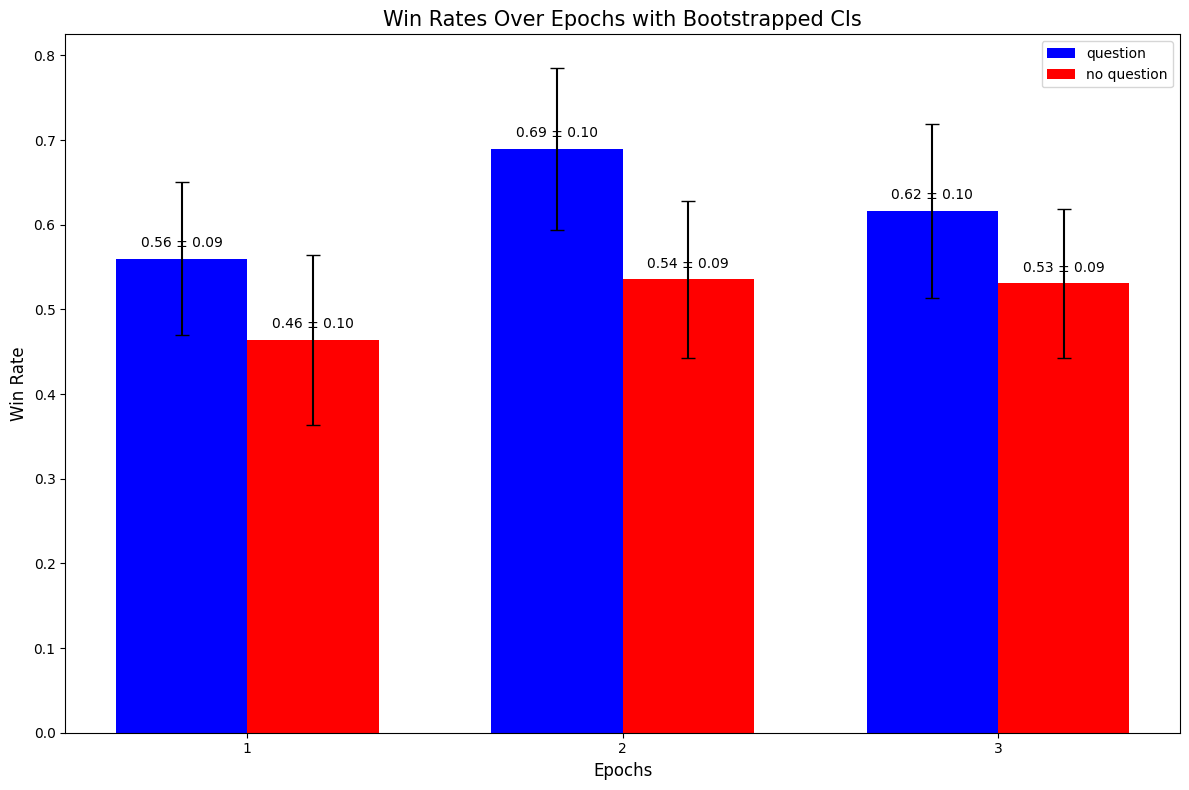

In [108]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load win rates data
win_rates_cot_1 = json.load(open("results/cot_distilled_epoch_1_win_rates_bias_short_long_answer.json", "r"))
win_rates_cot_1_q = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1) if q == 1]
win_rates_cot_1_nq = [w for w, q in zip(win_rates_cot_1, stargate_epoch_1) if q == 0]

win_rates_cot_2 = json.load(open("results/cot_distilled_epoch_2_win_rates_bias_short_long_answer.json", "r"))
win_rates_cot_2_q = [w for w, q in zip(win_rates_cot_2, stargate_epoch_2) if q == 1]
win_rates_cot_2_nq = [w for w, q in zip(win_rates_cot_2, stargate_epoch_2) if q == 0]

win_rates_cot_3 = json.load(open("results/cot_distilled_epoch_3_win_rates_bias_short_long_answer.json", "r"))
win_rates_cot_3_q = [w for w, q in zip(win_rates_cot_3, stargate_epoch_3) if q == 1]
win_rates_cot_3_nq = [w for w, q in zip(win_rates_cot_3, stargate_epoch_3) if q == 0]

# Calculate means and CIs
epochs = [1, 2, 3]
win_rates_cot_q = [win_rates_cot_1_q, win_rates_cot_2_q, win_rates_cot_3_q]
win_rates_cot_nq = [win_rates_cot_1_nq, win_rates_cot_2_nq, win_rates_cot_3_nq]

mean_cot_q = [np.mean(win_rate) for win_rate in win_rates_cot_q]
mean_cot_nq = [np.mean(win_rate) for win_rate in win_rates_cot_nq]

ci_cot_q = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_q]
ci_cot_nq = [1.96 * bootstrap_se(win_rate) for win_rate in win_rates_cot_nq]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.35
index = np.arange(len(epochs))

bars1 = ax.bar(index, mean_cot_q, bar_width, yerr=ci_cot_q, label='question', color='blue', capsize=5)
bars2 = ax.bar(index + bar_width, mean_cot_nq, bar_width, yerr=ci_cot_nq, label='no question', color='red', capsize=5)

ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Win Rate', fontsize=12)
ax.set_title('Win Rates Over Epochs with Bootstrapped CIs', fontsize=15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(epochs)
ax.legend()

# Adding text annotations with the exact win rates on top of each bar
for bars, mean, ci in zip([bars1, bars2], [mean_cot_q, mean_cot_nq], [ci_cot_q, ci_cot_nq]):
    for bar, m, c in zip(bars, mean, ci):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{m:.2f} ± {c:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
